In [1]:
import pickle
import os

import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns

from   einops                import rearrange
from   sklearn.decomposition import PCA

from   utils                 import load_data, process_data, run_svd
from   plotting              import plot_principal_movement, plot_all_movements, plot_state_space, plot_spectra
from   tqdm.notebook         import tqdm

from   behavelet             import wavelet_transform


# SET PARAMETERS
# signal filter
FILTER_CUTOFF = 5

# number of videos to calculate components
N_SELECT = 100

# number of principal movements / movement modes
N_MODES = 15

# time-frequency params
SAMPLE_FREQ = 25 # frequency of data
N_FREQS = 20
FMIN = 0.01
FMAX = 5

# data directories
DATA_DIR = 'trajectory_data/'

# output directories
FIGURE_DIR = 'figures/'
OUTPUT_DIR = 'outputs/'
os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

/home/gball/PROJECTS/babyMoves/state-space/state-space-env/lib/python3.10/site-packages/behavelet/morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


# Principal Component Analysis of keypoint trajectories
Following [Federolf, J Biomechanics, 2016](https://www.sciencedirect.com/science/article/pii/S0021929015007381), PCA applied to motion data can be interpreted as a set of Principal Movements (PM) that vary in contribution to the overall subject pose at any given time. Strength, variance or covariance of patterns over time could vary in clinical vs healthy populations. 

We use the same data as in the GMA prediction study. One video is removed as it is high resolution compared to the others, and one is removed as there is no age at video recorded.

To remove high-frequency frame-to-frame jitter, we filter all timeseries with a zero-phase 4th-order Butterworth lowpass filter with frequency cutoff 5Hz.

In [2]:
# load data
data, info = load_data(DATA_DIR)
    
n_s, n_t, n_k = np.shape(data)
print('data format: {:} subects by {:} time by {:} features'.format(n_s, n_t, n_k))

# rearrange for smoothing and angle calculation
processed_data = process_data(data, add_features=False, do_filter=True, filter_cutoff=FILTER_CUTOFF)[0]
processed_data = rearrange(processed_data, 'subjects time features -> subjects features time')

removing 1 outlier video
removing 1 videos with no age at video
data format: 486 subects by 4500 time by 36 features


### Plot of timeseries filtering

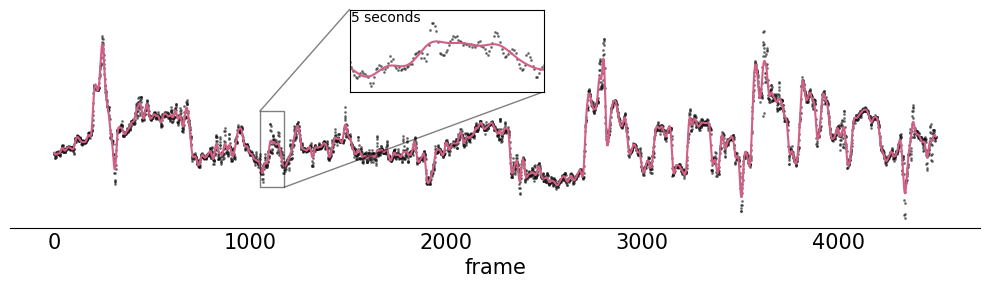

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
xdata = np.arange(4500)
ydata = (data[0,:4500,9] - np.mean(data[0,:4500,9])) # subect 0, keypoint 9
fdata = processed_data[0,9,:] - np.mean(processed_data[0,9,:])

ax.scatter(xdata, ydata, s=1, edgecolor='black', facecolor='grey', alpha=0.5)
ax.plot(fdata, lw=1.5, c='#d36084')
ax.set_yticklabels([])
ax.tick_params(length=0, labelsize=15)
ax.set_xlabel('frame', fontsize=15)

# inset axes....
axins = ax.inset_axes([0.35, 0.66, .2, .4])
axins.scatter(xdata, ydata, s=1, edgecolor='black', facecolor='grey', alpha=0.5)
axins.plot(fdata, lw=1.5, c='#d36084')

axins.set_xlim(1050, 1175)
axins.set_ylim(-5, 3)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(length=0)
axins.text(1051,1.8,'5 seconds')
ax.indicate_inset_zoom(axins, edgecolor="black")

sns.despine(ax=ax, left=True)

plt.tight_layout()
plt.savefig('{:}/signal_filter.png'.format(FIGURE_DIR), transparent=False)

Initially, just taking a random subset to build the model. This could be done in a CV loop, or using all subjects, or all healthy subjects etc. We should demonstrate that the PMs are stable given the training set.

In [4]:
# take random subset
print('')
print('select {:} at random'.format(N_SELECT))
rand_idx = np.arange(n_s)
np.random.shuffle(rand_idx)
model_data = processed_data[rand_idx[:N_SELECT],:,:]

#save record of subects in subset
info.to_csv('{:}all_subject_info.csv'.format(OUTPUT_DIR), index=None)
info.iloc[rand_idx[:N_SELECT]].to_csv('{:}decomposition_subset_info.csv'.format(OUTPUT_DIR), index=None)


select 100 at random


Each subjects timeseries are demeaned to remove body position and normalised to unit standard deviation to equalise the contribution of each to the PCA. So relatively small movements in a head keypoint, with relatively little freedom to move, are treated qually to larger movements in e.g.: foot points where there is more freedom to move. We can change this if neccesary.

In [5]:
# demean and standardise the timeseries of each coordinate within subject
subject_means = [] # save for reconstruction later
subject_norms = [] # save for reconstruction later
subject_data_normed = []

for i in tqdm(np.arange(len(model_data))):
    # demean
    subject_means.append(model_data[i].mean(axis=1))
    demeaned_data = model_data[i] -subject_means[i][:, np.newaxis]
    # norm
    subject_norms.append(np.std(demeaned_data, axis=1))
    subject_data_normed.append(demeaned_data / subject_norms[i][:, np.newaxis])

# concatenate timeseries across subjects
subject_data_normed = np.concatenate(subject_data_normed, axis=1).T
print('concatenated dimensions: {:} x {:}'.format(*subject_data_normed.shape))

  0%|          | 0/100 [00:00<?, ?it/s]

concatenated dimensions: 450000 x 36


### PCA decomposition
Perform PCA on concatenated movement data. See [Federolf](https://www.sciencedirect.com/science/article/pii/S0021929015007381) again  

For a $t$ timepoint $\times$ $n$ keypoint matrix, $M$, eigendecomposition of the $t \times t$ covariance matrix, $M^TM$ results in eigenvectors $v_k$ with associated eigenvalues $ev_k$. Each subjects normalised timeseries can be projected onto $v_k$ to give $\epsilon^{subj}_k$, component weights over time that "...quantify a position in posture space (i.e. how much the posture at time $t$ deviates from the mean posture in direction of $v_k$)..."

As $pxp$ is a 45,000 x 45,000 matrix (!), I've used SVD:

$$ 
M = USV^T
$$

where $V = eig(M^TM)$ and $U=eig(MM^T)$ such that columns of $V$ represent $v_k$ and columns of $US$ represent $\epsilon^{subj}_k$. The eigenvalues (variance explained by each movement in the full dataset) are given by $(S^2)/(t-1)$. 

In [6]:
subject_timeseries, principal_movements, singular_values, explained_variance_ratio = run_svd(subject_data_normed)

subject_timeseries = subject_timeseries[:, :N_MODES] * singular_values[:N_MODES][np.newaxis,:]

principal_movements = principal_movements[:N_MODES, :]
explained_variance_ratio = explained_variance_ratio[:N_MODES]

# save PCA output to OUTPUT_DIR
np.save('{:}principal_movements_timeseries_{:}components.npy'.format(OUTPUT_DIR, N_MODES), subject_timeseries)
np.save('{:}principal_movements_{:}components.npy'.format(OUTPUT_DIR, N_MODES), principal_movements)
np.save('{:}principal_movements_explained_variance_{:}components.npy'.format(OUTPUT_DIR, N_MODES), explained_variance_ratio)
np.save('{:}principal_movements_singular_values_{:}components.npy'.format(OUTPUT_DIR, N_MODES), singular_values[:N_MODES])


### Some plots
Here, we plot the PCA scree plot of the selected components. As well as some state-space plots and plots of each principal movement across the full range of weights.
    

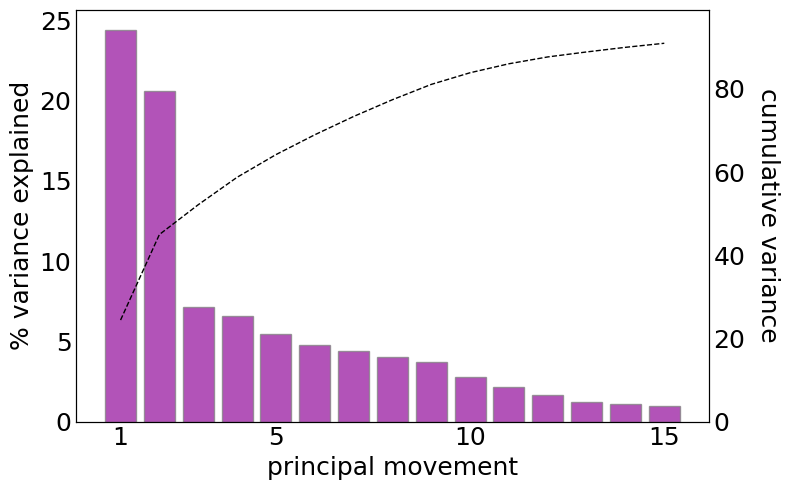

In [7]:
# variance explained by each principal movement

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax1 = ax.twinx()

ax.bar(x=np.arange(N_MODES)+1, height=explained_variance_ratio * 100, edgecolor='gray', alpha=0.75, facecolor='#9919a0', zorder=0)
ax.set_xlabel('principal movement', fontsize=18)
ax.set_ylabel('% variance explained', fontsize=18)
ax.set_xticks([1, 5, 10, 15, 20, 25])

ax.tick_params('both', labelsize=18, length=0)

ax1.plot(np.arange(N_MODES)+1, np.cumsum(explained_variance_ratio * 100), lw=1, color='black', linestyle='--')
ax1.set_ylim(0,99)
ax1.set_ylabel('cumulative variance', fontsize=18, rotation=270, labelpad=25)
ax1.tick_params('both', labelsize=18, length=0)

plt.tight_layout()
plt.savefig('{:}/movements_PCA_scree.png'.format(FIGURE_DIR), transparent=False)
plt.show()

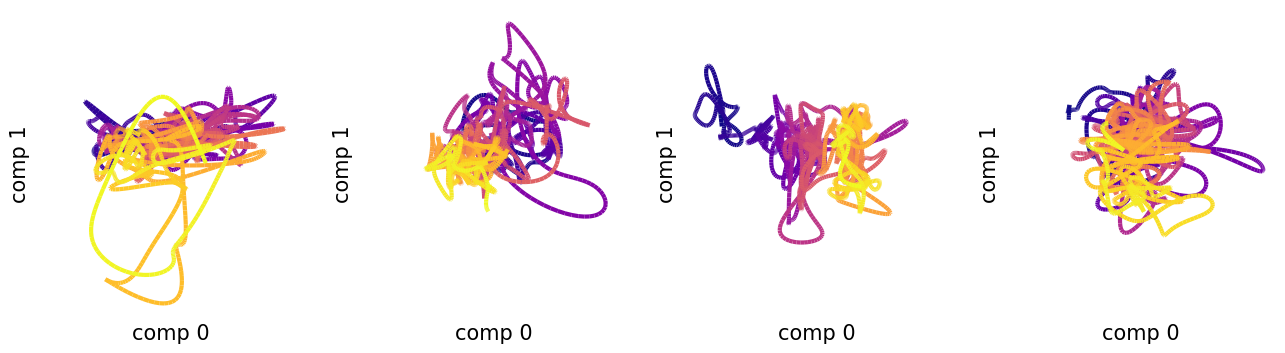

In [8]:
# State space trajectories - relationship between contributions of components to subjects movement over time
# (colour represents timepoint)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4), sharex=True, sharey=True)
plot_state_space(subject_timeseries[:4500], x=0, y=1, ax=ax1, lw=3, palette='plasma')
plot_state_space(subject_timeseries[4500:9000], x=0, y=1, ax=ax2, lw=3,palette='plasma')
plot_state_space(subject_timeseries[9000:13500], x=0, y=1, ax=ax3, lw=3,palette='plasma')
plot_state_space(subject_timeseries[13500:18000], x=0, y=1, ax=ax4, lw=3,palette='plasma')

plt.savefig('{:}/state_space_comp0_comp1.png'.format(FIGURE_DIR), transparent=False)

In [9]:
# principal movements - one per figure
all_movements = []
for component in tqdm(np.arange(N_MODES)):
    outpath = '{:}/principal_movements/component_{:02d}'.format(FIGURE_DIR, component)
    os.makedirs(outpath, exist_ok=True)

    # calculate weights and movement pattern
    min_comp = np.percentile(subject_timeseries[:,component], 5)
    max_comp = np.percentile(subject_timeseries[:,component], 95)

    z = 1/(1 + np.exp(-np.linspace(-5,5,50))) 
    z = z * (max_comp - min_comp) + min_comp
    z = np.concatenate((z, z[::-1]))

    movement_pattern = z[:,np.newaxis].dot(principal_movements[component,:][np.newaxis,:])
    recon_movement = np.mean(subject_means, axis=0) + (np.mean(subject_norms, axis=0) * movement_pattern)
    all_movements.append(recon_movement[:,:36])
    # plot (just movements)
    plot_principal_movement(recon_movement[:,:36], z, outpath)
    
# principal movements - all in one figure
outpath = '{:}/principal_movements/all_components'.format(FIGURE_DIR)
os.makedirs(outpath, exist_ok=True)
plot_all_movements(all_movements, outpath)

  0%|          | 0/15 [00:00<?, ?it/s]

### Morlet Continuous Wavelet Transform of movement signal

Following [Berman et al.](https://royalsocietypublishing.org/doi/10.1098/rsif.2014.0672), a study focused on behavioural clustering of movement data (in flies), we can incorporate dynamic information in each frame via a continuous wavelet transform (CWT).

After PCA decomposition, each subject's position data is represented as an $k$-dimensional timeseries of principal movement weights.

$$
Y = \{y_1(t), y_2(t), ..., y_k(t)\}
$$

Posture at a given frame is an instantaneuous measure and doesn't consider how posture is changing over time. CWT produces a spectrogram representing power at a given frequency, $f$, for each postural mode, $y_k(t)$ in a window surrounding each frame. Based on a [Morlet wavelet](https://www.sciencedirect.com/science/article/abs/pii/0016714284900255) - a tapering sine wave - with a given width, a dictionary of wavelets with varying frequencies/widths are generating and the cross-correlation with each timeseries calculated at each frame. 

The resulting spectogram, $S(k, f; t)$ contains wavelet coeffients for each component, $k$, at each frequency, $f$, for each timepoint, $t$. A higher value indicating more movement at that (and surrounding) timepoints in a given frequency band.

Using the [`behavelet`](https://github.com/jgraving/behavelet) package, a Python implementation of the Berman algorithms, we calculate power at 20 frequencies spaced logarithmically from 0.1 to 5Hz for each of the postural modes. The resulting spectrogram is concatenated into a $component \times frequency$ length vector per frame.

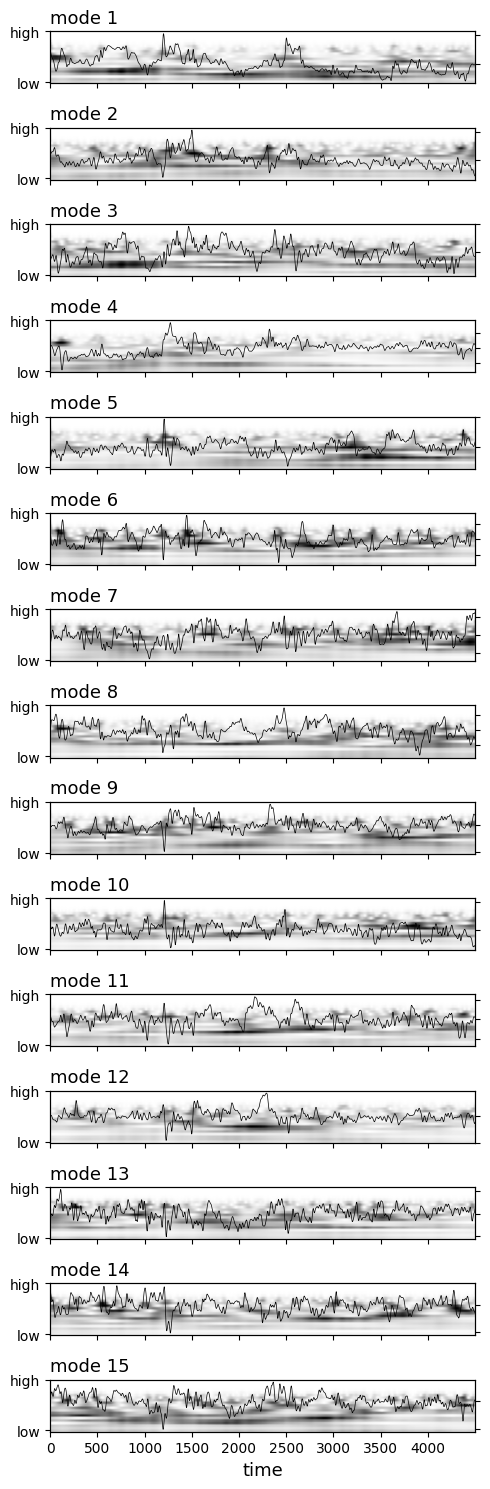

In [10]:
# rearrange to subject x component x time
pc_timeseries = rearrange(subject_timeseries, '(subject time) comp -> subject comp time', time=4500)

# check it worked as expected!
assert np.allclose(subject_timeseries[4500:9000, 5], pc_timeseries[1, 5, :])

tf_timeseries = []

# for each mode
for pc in pc_timeseries:
    # normalise across time
    pc = pc / np.std(pc, axis=-1)[:,np.newaxis]
    # calculate power at each frequency
    freqs, power, X_new = wavelet_transform(pc.T, n_freqs=N_FREQS, prob=True, log_scale=True, fsample=SAMPLE_FREQ, fmin=FMIN, fmax=FMAX)
    tf_timeseries.append(X_new.T)

# plot spectra for a single subject
plot_spectra(tf_timeseries[1], pc_timeseries[1], n_freqs=N_FREQS, n_comps=N_MODES, outpath=FIGURE_DIR)

# plot shows spectrogram with timeseries of principal movement overlaid, higher power is shown as darker shades for each frame

### Decomposition of time-frequency signal

Each frame is represented by a $k$-component $\times f$-frequencies length vector representing spectral power over a series of frequencies. We can use PCA again to reduce the dimensionality of the spectrogram. Here, the $k \times f$ spectral ($kf$) features x $t$ timepoint matrix is decomposed to give eigenvectors $v_k$ with associated eigenvalues $s_k$ and component weights that show how each $kf$ component (weighted combination of the power of a given principal movement at a given frequency!) deviates from the mean in the direction $v_k$

As the spectrograms are quite noisy and there is no decent way of gaining intuition on if components are 'real' or not. The number of components to use is selected through comparison to equivalent random matrices. This can be based on a permutation test, where each column of the data matrix is shuffled independently to remove covariance in $M^TM$ while retaining the original feature distributions. Or through comparison to a theoretical distribution (Marchenko-Pastur distribution) which describes the distribution of eigenvalues for matrices of a given size with random i.i.d. data with zero mean and std=1. Eigenvalues from the empirical data that are smaller than the maximum defined by the null models can be considered at the same scale as noise due to sampling error and are removed. For this data there is very little power in the highest frequencies, and the standard deviation is tiny, so scaling each to std=1 would substantially increase contribution of these small noisy values. As such, the data are not scaled (therefore do not have std=1) and the (slower) permutation method is used as this respects the distributions of the variables.



In [11]:
tf_data =[]
for i in tqdm(np.arange(len(tf_timeseries))):
    
    # rearrange to order features by frequency instead of component (nicer to visualise) 
    d = rearrange(tf_timeseries[i], '(s f) t -> (f s) t', f=N_FREQS)
    tf_data.append(d)
    
# concatenate timeseries across subjects
tf_data = np.concatenate(tf_data, axis=1).T
mean_tf_data =  np.mean(tf_data, axis=0)
tf_data = tf_data - mean_tf_data

  0%|          | 0/100 [00:00<?, ?it/s]

Text(240, 0.001, 'not much \nvariance \nhere')

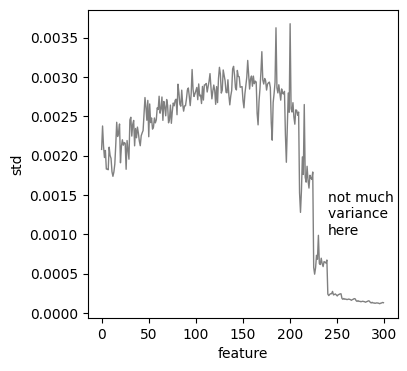

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4, 4))
ax.plot(np.std(tf_data, axis=0), lw=1, c='grey')
ax.set_xlabel('feature')
ax.set_ylabel('std')
ax.text(240, 0.0010, 'not much \nvariance \nhere')

In [13]:
# SVD
tf_components, tf_eigenvectors, tf_singular_values, tf_explained_variance_ratio, tf_significant_comps, threshold = run_svd(tf_data, significance='perm', n_perms=500)

tf_num_comps = np.sum(tf_significant_comps)
print('{:} components explained more variance than null model'.format(tf_num_comps))

tf_components = tf_components[:, :tf_num_comps]  *  tf_singular_values[:tf_num_comps][np.newaxis,:]
tf_eigenvectors = tf_eigenvectors[:tf_num_comps, :]
tf_explained_variance_ratio = tf_explained_variance_ratio[:tf_num_comps]

# save PCA output to OUTPUT_DIR
np.save('{:}dynamicfeatures_timeseries_{:}components.npy'.format(OUTPUT_DIR, tf_num_comps), tf_components)
np.save('{:}dynamicfeatures_eigenvectors_{:}components.npy'.format(OUTPUT_DIR, tf_num_comps), tf_eigenvectors)
np.save('{:}dynamicfeatures_explained_variance_{:}components.npy'.format(OUTPUT_DIR, tf_num_comps), tf_explained_variance_ratio)

running 500 permutations to estimate null distribution


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:26:05<00:00, 17.53s/it]

23 components explained more variance than null model


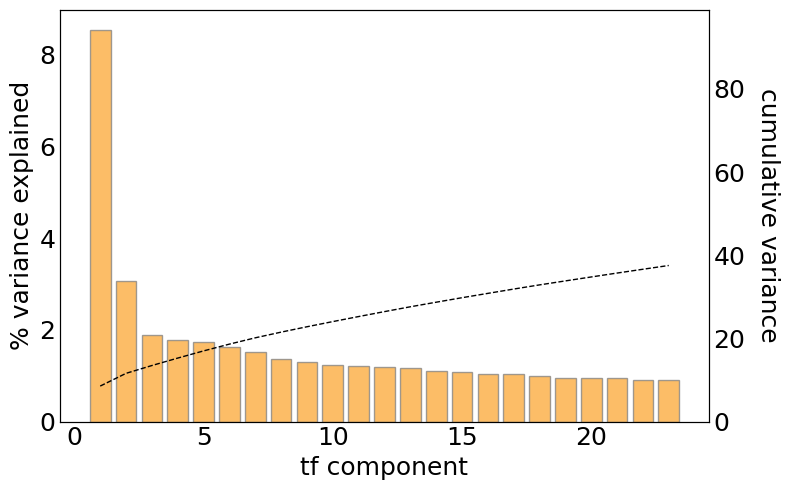

In [14]:
# variance explained by each time-frequency component
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax1 = ax.twinx()

ax.bar(x=np.arange(tf_num_comps)+1, height=tf_explained_variance_ratio * 100, edgecolor='gray', alpha=0.75, facecolor='#fba734', zorder=0)
ax.set_xlabel('tf component', fontsize=18)
ax.set_ylabel('% variance explained', fontsize=18)

ax.tick_params('both', labelsize=18, length=0)

ax1.plot(np.arange(tf_num_comps)+1, np.cumsum(tf_explained_variance_ratio * 100), lw=1, color='black', linestyle='--')
ax1.set_ylim(0,99)
ax1.set_ylabel('cumulative variance', fontsize=18, rotation=270, labelpad=25)
ax1.tick_params('both', labelsize=18, length=0)

plt.tight_layout()
plt.savefig('{:}/dynamicfeatures_PCA_scree.png'.format(FIGURE_DIR), transparent=False)
plt.show()

# only small amount of variance explained = noisy spectra?

### Project all subject's data into feature space

Using precalculated eigenvectors, we can now project the remaining subject's movement data into the same feature space for modelling.

Final data saved for further analysis.

In [15]:
posture_data = []
dynamic_data = []
# for each subject
for i in tqdm(np.arange(len(processed_data))):
    d = processed_data[i]
    # remove timeseries mean
    d = d - np.mean(d, axis=1)[:, np.newaxis]
    # norm to std=1
    d = d / np.std(d, axis=1)[:, np.newaxis]
    # dot with eigenvectors
    d = d.T.dot(principal_movements.T).T
    posture_data.append(d)
    # normalise across time with std=1
    d = d / np.std(d, axis=1)[:, np.newaxis]
    _, _, w = wavelet_transform(d.T, n_freqs=N_FREQS, prob=True, log_scale=True, fsample=SAMPLE_FREQ, fmin=FMIN, fmax=FMAX)
    # rearrange to frequency first ordering as above
    w = rearrange(w, 't (s f) -> t (f s)', f=N_FREQS)
    # subtract precalculated mean
    w = w - mean_tf_data
    # project onto time-frequency components
    w = w.dot(tf_eigenvectors.T)
    # transpose to feature x time to match posture features and concatenate
    dynamic_data.append(w.T)
    
# check it worked as expected
assert np.allclose(tf_components[:4500,:], dynamic_data[rand_idx[0]].T)

# concatenate posture and dynamic data
final_data = np.array([np.concatenate((i,j), axis=0) for i,j in zip(posture_data, dynamic_data)])
# standardise each feature's timeseries within subects to std=1
final_data = final_data / np.std(final_data, axis=-1)[:,:,np.newaxis]

# save out
np.save('{:}processed_timeseries_data.npy'.format(OUTPUT_DIR, final_data), final_data)

  0%|          | 0/486 [00:00<?, ?it/s]